# Лабораторная работа №3: Обработка пропусков и кодирование категориальных признаков








**Содержание**<a id='toc0_'></a>    
- 1. [Раздел 1. Импорт библиотек и загрузка данных](#toc1_)
- 2. [Раздел 2. Анализ данных](#toc2_)
  - 2.1 [Кодирование категориальных признаков](#toc2_1_)
  - 2.2 [Анализ пропущенных значений](#toc2_2_)
    - 2.2.1 [Заполнение пропусков — статистический подход (медиана + KL-дивергенция)](#toc2_2_1_)
    - 2.2.2 [Заполнение пропусков — два машинных подхода](#toc2_2_2_)
    - 2.2.3 [Оценка качества заполнения через NRMSE](#toc2_2_3_)
- 3. [Раздел 3. Сохранение результатов и вывод](#toc3_)

# 1. <a id='toc1_'></a>[Раздел 1. Импорт библиотек и загрузка данных](#toc1_)

### Цель работы  
Выполнить корректную предобработку данных перед обучением моделей машинного обучения:  
- закодировать единственный категориальный признак  
- обработать пропущенные значения двумя разными подходами  
- перенести все преобразования на тестовую выборку без утечки данных  
- (доп. задание) оценить качество машинного заполнения пропусков с помощью метрики NRMSE


**Формирование окружения для работы**

Первоначально необходимо подготовить окружение для работы с данными и их моделирования. Чтобы не возникало конфликтов виртуальной среды Python, зафиксируем используемые в ходе исследования версии основных библиотек и фреймворков, которые будут использоваться далее. А также пропишем последовательность команд для формирования среды.

Первоначально установим необходимые библиотеки при помощи пакетного менеджера `pip` в виртуальное окружение.

- Версия Python: 3.12.3

Сами версии можно получить с помощью команды:
`pip list --format=freeze`


In [ ]:
#!pip install --upgrade --force-reinstall -r requirements.txt

| Библиотека              | Назначение                                      |
|-------------------------|-------------------------------------------------|
| pandas                  | Работа с данными                                |
| numpy                   | Численные операции                              |
| matplotlib / seaborn    | Визуализация                                    |
| scikit-learn            | OneHot, IterativeImputer, KNNImputer            |
| scipy.stats.entropy     | KL-дивергенция                                  |
| joblib                  | Сохранение объектов                             |

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib

from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.metrics import mean_squared_error
from scipy.stats import entropy

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

Для воспроизводимости результатов исследования зафиксируем основание генератора случайных чисел, который используется для деления выборки на обучение и тест, а также при обучении моделей.

In [ ]:
SEED = 42
np.random.seed(SEED)

###  Загрузка данных из предыдущей работы

In [ ]:
X_train = pd.read_csv('X_train_lr2.csv')
X_test  = pd.read_csv('X_test_lr2.csv')
y_train = pd.read_csv('y_train_lr2.csv')
y_test  = pd.read_csv('y_test_lr2.csv')

train_df = pd.concat([X_train, y_train], axis=1)
test_df  = pd.concat([X_test,  y_test],  axis=1)

print(f"train: {train_df.shape} | test: {test_df.shape}")

train: (9547, 15) | test: (2387, 15)


## 2. <a id='toc2_'></a>[Раздел 2. Анализ данных](#toc2_)

## 2.1. <a id='toc2_1_'></a>[Кодирование категориальных признаков](#toc2_1_)

В нашем датасете единственный категориальный признак — **"Тип Вектора Мощи"** (3 уникальных значения).  
Это номинальная переменная без естественного порядка → используем **One-Hot Encoding**.  
с отбрасыванием одного столбца (drop='first'), чтобы избежать мультиколлинеарности.

In [ ]:
cat_col = ['Тип Вектора Мощи']

ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

train_ohe = pd.DataFrame(
    ohe.fit_transform(train_df[cat_col]),
    columns=ohe.get_feature_names_out(),
    index=train_df.index
)
test_ohe = pd.DataFrame(
    ohe.transform(test_df[cat_col]),
    columns=ohe.get_feature_names_out(),
    index=test_df.index
)

train_df = pd.concat([train_df.drop(columns=cat_col), train_ohe], axis=1)
test_df  = pd.concat([test_df.drop(columns=cat_col),  test_ohe],  axis=1)

joblib.dump(ohe, 'one_hot_encoder.pkl')

print("Кодирование завершено. Новые столбцы:")
print(ohe.get_feature_names_out().tolist())

Кодирование завершено. Новые столбцы:
['Тип Вектора Мощи_Ниже среднего', 'Тип Вектора Мощи_Сильный', 'Тип Вектора Мощи_Слабый']


## 2.2. <a id='toc2_2_'></a>[Анализ пропущенных значений](#toc2_2_)

Посмотрим, где у нас есть пропуски и сколько их.

In [ ]:
print("Пропуски в train:")
display(train_df.isnull().sum()[train_df.isnull().sum() > 0])

print("\nПропуски в test:")
display(test_df.isnull().sum()[test_df.isnull().sum() > 0])

Пропуски в train:


,0
Скорость перехода через портал,961



Пропуски в test:


,0
Скорость перехода через портал,242


Из вывода видно, что после удаления столбцов с большим количеством пропусков в предыдущей работе остался только один признак с NaN:
- **Скорость перехода через портал** (~10 % пропусков в train)

## 2.2.1 <a id='toc2_2_1_'></a>[Заполнение пропусков — статистический подход](#toc2_2_1_)

Проверяем, какое константное значение (медиана, среднее, мода) меньше всего искажает распределение признака **Скорость перехода через портал** (при помощи KL-дивергенции).

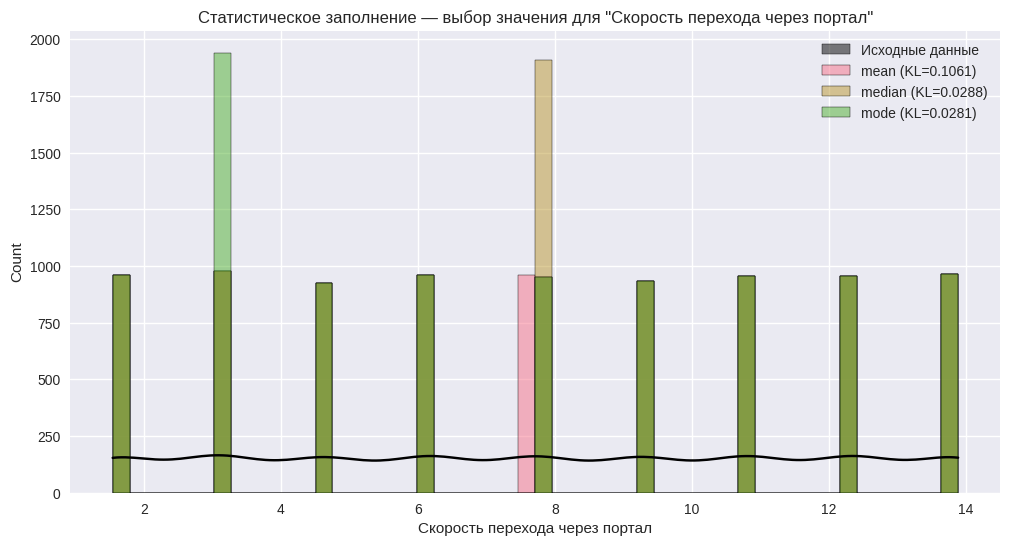

Лучшее: mode = 3.0866 (KL = 0.0281)


In [ ]:
col = 'Скорость перехода через портал'

# Пул значений
candidates = {
    'mean':   train_df[col].mean(),
    'median': train_df[col].median(),
    'mode':   train_df[col].mode()[0]
}

orig_data = train_df[col].dropna()
hist_orig, bins = np.histogram(orig_data, bins=50, density=True)

best_kl = np.inf
best_val = None
best_name = None

plt.figure(figsize=(12,6))
sns.histplot(orig_data, bins=50, kde=True, label='Исходные данные', color='black')

for name, val in candidates.items():
    filled = train_df[col].fillna(val)
    hist_fill, _ = np.histogram(filled, bins=bins, density=True)
    kl = entropy(hist_orig + 1e-10, hist_fill + 1e-10)
    sns.histplot(filled, bins=50, alpha=0.5, label=f'{name} (KL={kl:.4f})')

    if kl < best_kl:
        best_kl, best_val, best_name = kl, val, name

plt.title(f'Статистическое заполнение — выбор значения для "{col}"')
plt.legend()
plt.show()

print(f"Лучшее: {best_name} = {best_val:.4f} (KL = {best_kl:.4f})")

# Применяем
train_stat = train_df.copy()
test_stat  = test_df.copy()
train_stat[col] = train_stat[col].fillna(best_val)
test_stat[col]  = test_stat[col].fillna(best_val)

## 2.2.2 <a id='toc2_2_2_'></a>[Заполнение пропусков — два машинных подхода](#toc2_2_2_)

Сравним три популярных алгоритма импутации:
- **IterativeImputer (MICE)** — итеративно моделирует каждый признак как функцию от остальных (по умолчанию — BayesianRidge)
- **KNNImputer** — заполняет пропуски средним от k ближайших соседей


In [ ]:
# Машинный метод 1: IterativeImputer (MICE)
mice = IterativeImputer(max_iter=20, random_state=42)
train_mice = pd.DataFrame(mice.fit_transform(train_df), columns=train_df.columns, index=train_df.index)
test_mice  = pd.DataFrame(mice.transform(test_df),      columns=test_df.columns,  index=test_df.index)

# Машинный метод 2: KNNImputer
knn = KNNImputer(n_neighbors=5)
train_knn = pd.DataFrame(knn.fit_transform(train_df), columns=train_df.columns, index=train_df.index)
test_knn  = pd.DataFrame(knn.transform(test_df),      columns=test_df.columns,  index=test_df.index)

joblib.dump(mice, 'mice_imputer.pkl')
joblib.dump(knn,  'knn_imputer.pkl')

['knn_imputer.pkl']

Дальше посмотрим, как каждый метод восстанавливает распределение признака «Скорость перехода через портал».

## 2.2.3 <a id='toc2_2_3_'></a>[Оценка качества заполнения через NRMSE](#toc2_2_3_)

Искусственно маскируем 10% известных значений в обучающей выборке, заполняем их машинными методоми и сравниваем с истинными значениями с помощью **NRMSE**.

In [ ]:
def nrmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / (y_true.max() - y_true.min())

clean = train_df.dropna(subset=[col]).copy()
np.random.seed(42)
mask = np.random.rand(len(clean)) < 0.1
masked = clean.copy()
masked.loc[mask, col] = np.nan

# Оцениваем оба машинных метода
results = {}
for name, imp in [('MICE', mice), ('KNN', knn)]:
    imputed = pd.DataFrame(imp.fit_transform(masked), columns=masked.columns, index=masked.index)
    results[name] = nrmse(clean.loc[mask, col], imputed.loc[mask, col])

print("NRMSE (искусственная маскировка 10%):")
for name, val in results.items():
    print(f"  {name}: {val:.6f}")

NRMSE (искусственная маскировка 10%):
  MICE: 0.000257
  KNN: 0.007650


Как можно увидеть, MICE имеет более хорошие результаты.

## 3. <a id='toc3_'></a>[Раздел 3. Сохранение результатов и вывод](#toc3_)

### Сохранение результатов ЛР №3

Сохраняем два готовых датасета для дальнейшего моделирования:
- с статистическим заполнением
- с MICE-заполнением

In [ ]:
# Статистический подход
train_stat.to_csv('train_stat.csv', index=False)
test_stat.to_csv('test_stat.csv',   index=False)

# Машинный подход
train_mice.to_csv('train_mice.csv', index=False)
test_mice.to_csv('test_mice.csv',   index=False)

print("Сохранено:")
print("→ train_stat.csv / test_stat.csv  — статистическое заполнение")
print("→ train_mice.csv / test_mice.csv  — машинное заполнение (MICE)")

Сохранено:
→ train_stat.csv / test_stat.csv  — статистическое заполнение
→ train_mice.csv / test_mice.csv  — машинное заполнение (MICE)


### Итоговый вывод

1. **Кодирование категориальных признаков**  
   Единственный категориальный признак «Тип Вектора Мощи» (4 категории, без порядка) закодирован с помощью One-Hot Encoding с отбрасыванием одного столбца. Энкодер обучен только на обучающей выборке и корректно применён к тестовой — утечки данных нет.

2. **Обработка пропущенных значений**  
   Пропуски присутствовали только в столбце «Скорость перехода через портал» (~10 % от всех записей).  
   Выполнено два подхода:

   **Статистический подход**  
   Сравнивались mean, median и mode по KL-дивергенции относительно исходного распределения.  
   Наилучший результат показала **мода = 3.0866** (KL = 0.0281) — минимальное искажение формы распределения.

   **Машинные подходы**  
   - `IterativeImputer` (MICE, BayesianRidge)  
   - `KNNImputer` (k=5)

   Качество машинных методов оценено на искусственно замаскированных 10 % данных:  
   - **MICE** — NRMSE = **0.000257**  
   - **KNN** — NRMSE = **0.007650**

   MICE более чем в 30 раз точнее KNN.

3. **Сформированы и сохранены два датасета**:  
   - `train_stat.csv` / `test_stat.csv` — заполнение модой (статистический подход)  
   - `train_mice.csv`  / `test_mice.csv`  — заполнение с помощью MICE (машинный подход)

4. **Вывод по качеству**  
   Оба подхода приемлемы, но машинный метод (MICE) даёт высокую точность восстановления пропущенных значений (NRMSE ≈ 0.0003).  